# Using JAX as Backend

Showcase how to use jitable jax models.

In [1]:
import keras as ks

In [2]:
print(ks.backend.backend())

jax


In [3]:
import numpy as np
from kgcnn.literature.GIN import make_model_edge as make_model
from kgcnn.utils.plots  import plot_train_test_loss
from sklearn.model_selection import train_test_split

In [4]:
from kgcnn.data.datasets.FreeSolvDataset import FreeSolvDataset
dataset = FreeSolvDataset()

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name FreeSolv
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.FreeSolv:Found SDF C:\Users\patri\.kgcnn\datasets\FreeSolv\SAMPL.sdf of pre-computed structures.
INFO:kgcnn.data.FreeSolv:Read molecules from mol-file.
INFO:kgcnn.data.FreeSolv: ... process molecules 0 from 642
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['C', 'N', 'O', 'S', 'Cl', 'Br', 'P', 'F', 'I']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP2, rdkit.Chem.rdchem.HybridizationType.SP]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [4, 3, 1, 2]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalNumHs found [3, 0, 1, 2, 4]
INFO:kgcnn.molecule.encoder:OneHotEncoder CIPCode found [None, '

## Padded input

With keeping the padded input in the disjoint representation and adding a dummy graph for the padded values which can be achieved with the `padded_disjoint` argument for the cast to disjoint layers in `"cast_disjoint_kwargs": {"padded_disjoint": True}` , the model can be jited.
However, this will yield a significant number of padded values for node or edge attributes.
For better performance it is better to padd the entire batch/disjoint node or edge tensors which requires a dataloader.

Note that for the moment special layers like `BatchNormalization` must also passed the argument `padded_disjoint` but which is not yet fully supported.

In [5]:
model_config = {
    "name": "GINE",
    "inputs": [
        {"shape": (None, 41), "name": "node_attributes", "dtype": "float32"},
        {"shape": (None, 11), "name": "edge_attributes", "dtype": "float32"},
        {"shape": (None, 2), "name": "edge_indices", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},  # Or mask
        {"shape": (), "name": "total_edges", "dtype": "int64"},  # Or mask
    ],
    "input_tensor_type": "padded",
    "cast_disjoint_kwargs": {"padded_disjoint": True},
    "input_embedding": None,  # deprecated
    "input_node_embedding": {"input_dim": 95, "output_dim": 64},
    "input_edge_embedding": {"input_dim": 10, "output_dim": 64},
    "gin_mlp": {"units": [64, 64], "use_bias": True, "activation": ["relu", "linear"],
                # At the moment we do not have a batch normalization for padded_disjoint
                "use_normalization": False, 
                "normalization_technique": "graph_batch"},
    "gin_args": {"epsilon_learnable": False},
    "depth": 3, "dropout": 0.0, "verbose": 10,
    "last_mlp": {"use_bias": [True, True, True], "units": [64, 64, 64],
                 "activation": ["relu", "relu", "linear"]},
    "output_embedding": 'graph',
    "output_to_tensor": None,
    "output_scaling": None,
    "output_tensor_type": "padded",
    "output_mlp": {"use_bias": True, "units": 1,
                   "activation": "linear"}
}
inputs = model_config["inputs"]
outputs = {"shape": (1, ), "name": "graph_labels", "dtype": "float32"}

In [6]:
dataset.map_list(method="count_nodes_and_edges")
dataset.clean(inputs)
for i in range(len(dataset)):
    if len(dataset[i]["graph_labels"].shape) < 1:
        dataset[i]["graph_labels"] = np.expand_dims(dataset[i]["graph_labels"], axis=-1)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2)

x_train = dataset[train_indices].tensor(inputs)
y_train = dataset[train_indices].tensor(outputs)
x_test = dataset[test_indices].tensor(inputs)
y_test = dataset[test_indices].tensor(outputs)

INFO:kgcnn.data.FreeSolv:Property 'edge_attributes' is an empty list for graph '61'.
INFO:kgcnn.data.FreeSolv:Property 'edge_attributes' is an empty list for graph '195'.
INFO:kgcnn.data.FreeSolv:Property 'edge_attributes' is an empty list for graph '286'.
INFO:kgcnn.data.FreeSolv:Property 'edge_indices' is an empty list for graph '61'.
INFO:kgcnn.data.FreeSolv:Property 'edge_indices' is an empty list for graph '195'.
INFO:kgcnn.data.FreeSolv:Property 'edge_indices' is an empty list for graph '286'.


In [7]:
model = make_model(**model_config)
model.compile(
    loss="mean_absolute_error", 
    optimizer=ks.optimizers.Adam(learning_rate=1e-03),
    jit_compile=True
)
print(" Compiled with jit: %s" % model._jit_compile)

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'GINE', 'inputs': [{'shape': (None, 41), 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': (None, 11), 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'cast_disjoint_kwargs': {'padded_disjoint': True}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 10, 'output_dim': 64}, 'gin_mlp': {'units': [64, 64], 'use_bias': True, 'activation': ['relu', 'linear'], 'use_normalization': False, 'normalization_technique': 'graph_batch'}, 'gin_args': {'epsilon_learnable': False}, 'depth': 3, 'dropout': 0.0, 'verbose': 10, 'last_mlp': {'use_bias': [True, True, True], 'units': [64, 64, 64], 'activation': ['relu', 'relu', 'linear']}, 'output_embedding': 'graph', 

 Compiled with jit: True


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\src\backend\jax\core.py:76: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\src\backend\jax\numpy.py:224: UserWarning: Explicitly requested dtype int64 requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.arange(start, stop, step=step, dtype=dtype)


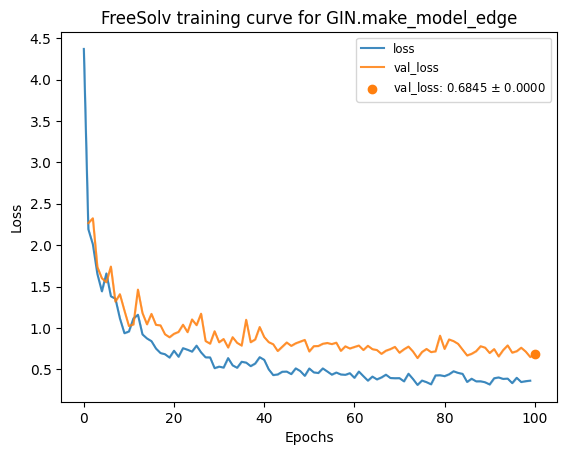

0.3643649220466614


In [8]:
hist = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test),
    epochs=100, 
    verbose=0
)
plot_train_test_loss([hist], dataset_name="FreeSolv", model_name="GIN.make_model_edge");
print(hist.history["loss"][-1])

## Dataloader

The best way for training is to use a dataloader to generate a padded disjoint representation.
One could recompile the model for each batch and run a fixed batch size. However, this is not tested and implemented.
For now you can give the number of epochs and it will generate the maximum batch disjoint representation for the entire training process.

In [9]:
model_config = {
    "name": "GINE",
    "inputs": [
        {"shape": (41, ), "name": "node_attributes", "dtype": "float32"},
        {"shape": (11, ), "name": "edge_attributes", "dtype": "float32"},
        {"shape": (None, ), "name": "edge_indices", "dtype": "int64"},  # shape is (2, None)
        {"shape": (), "name": "batch_id_node", "dtype": "int64"},
        {"shape": (), "name": "batch_id_edge", "dtype": "int64"},
        {"shape": (), "name": "node_id", "dtype": "int64"},
        {"shape": (), "name": "edge_id", "dtype": "int64"},
        {"shape": (), "name": "count_nodes", "dtype": "int64"},
        {"shape": (), "name": "count_edges", "dtype": "int64"},
    ],
    "input_tensor_type": "disjoint",
    "cast_disjoint_kwargs": {"padded_disjoint": True},
    "input_embedding": None,  # deprecated
    "input_node_embedding": {"input_dim": 95, "output_dim": 64},
    "input_edge_embedding": {"input_dim": 10, "output_dim": 64},
    "gin_mlp": {"units": [64, 64], "use_bias": True, "activation": ["relu", "linear"],
                # At the moment we do not have a batch normalization for padded_disjoint
                "use_normalization": False, 
                "normalization_technique": "graph_batch"},
    "gin_args": {"epsilon_learnable": False},
    "depth": 3, "dropout": 0.0, "verbose": 10,
    "last_mlp": {"use_bias": [True, True, True], "units": [64, 64, 64],
                 "activation": ["relu", "relu", "linear"]},
    "output_embedding": 'graph',
    "output_to_tensor": None,
    "output_scaling": None,
    "output_tensor_type": "padded",
    "output_mlp": {"use_bias": True, "units": 1,
                   "activation": "linear"}
}
inputs = model_config["inputs"]
outputs = {"shape": (1, ), "name": "graph_labels", "dtype": "float32"}

In [10]:
model = make_model(**model_config)
model.compile(
    loss="mean_absolute_error", 
    optimizer=ks.optimizers.Adam(learning_rate=1e-03),
    jit_compile=True
)
print(" Compiled with jit: %s" % model._jit_compile)

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'GINE', 'inputs': [{'shape': (41,), 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': (11,), 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': (None,), 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'batch_id_node', 'dtype': 'int64'}, {'shape': (), 'name': 'batch_id_edge', 'dtype': 'int64'}, {'shape': (), 'name': 'node_id', 'dtype': 'int64'}, {'shape': (), 'name': 'edge_id', 'dtype': 'int64'}, {'shape': (), 'name': 'count_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'count_edges', 'dtype': 'int64'}], 'input_tensor_type': 'disjoint', 'cast_disjoint_kwargs': {'padded_disjoint': True}, 'input_embedding': None, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 10, 'output_dim': 64}, 'gin_mlp': {'units': [64, 64], 'use_bias': True, 'activation': ['relu', 'linear'], 'use_normalization': False, 'normalization_technique': 'graph_batch'}, 'gin_args': {'e

 Compiled with jit: True


INFO:kgcnn.io.loader:Max of graph: {0: 24, 1: 50, 2: 50, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None}.
INFO:kgcnn.io.loader:Padded max of disjoint: [10.875, 22.0625, 22.0625, None, None, None, None, None, None].
INFO:kgcnn.io.loader:Max of graph: {0: 23, 1: 48, 2: 48, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None}.
INFO:kgcnn.io.loader:Padded max of disjoint: [10.96875, 21.6875, 21.6875, None, None, None, None, None, None].


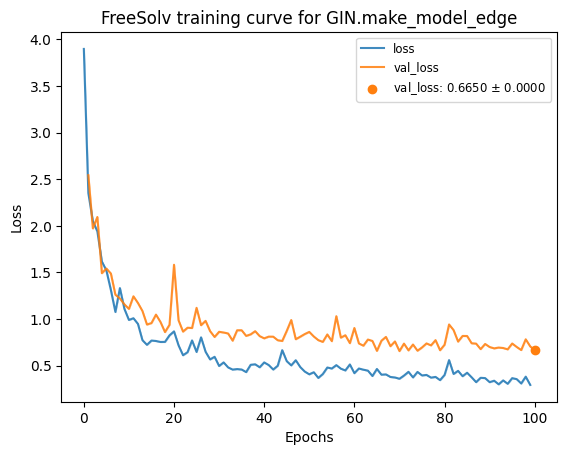

0.2942376434803009


In [11]:
import tensorflow as tf
# For train
dataset_train = dataset[train_indices]
dataloader_train_x = dataset_train.tf_dataset_disjoint(
    inputs=inputs, 
    batch_size=32, 
    assignment_to_id=[0, 1, 1],
    assignment_of_indices=[None, None, 0],
    pos_batch_id=[3,4],
    pos_subgraph_id=[5,6],
    pos_count=[7,8],
    epochs=100,
    padded_disjoint=True
)
dataloader_train_y = dataset_train.tf_dataset_disjoint(
    inputs=outputs, 
    batch_size=32, 
    epochs=100,
    padded_disjoint=False
)
dataloader_train = tf.data.Dataset.zip((dataloader_train_x, dataloader_train_y))
# For test
dataset_test = dataset[test_indices]
dataloader_test_x = dataset_test.tf_dataset_disjoint(
    inputs=inputs, 
    batch_size=32, 
    assignment_to_id=[0, 1, 1],
    assignment_of_indices=[None, None, 0],
    pos_batch_id=[3,4],
    pos_subgraph_id=[5,6],
    pos_count=[7,8],
    epochs=100,
    padded_disjoint=True
)
dataloader_test_y = dataset_test.tf_dataset_disjoint(
    inputs=outputs, 
    batch_size=32, 
    epochs=100,
    padded_disjoint=False
)
dataloader_test = tf.data.Dataset.zip((dataloader_test_x, dataloader_test_y))
hist = model.fit(
    dataloader_train, 
    validation_data=dataloader_test, 
    epochs=100,
    verbose=0
)
plot_train_test_loss([hist], dataset_name="FreeSolv", model_name="GIN.make_model_edge");
print(hist.history["loss"][-1])